# Post Analysis of timescaledb

Using the timescaledb credential, we are going to retrieve the inserted data from the database. From this data, we can detect the number of successful insert per experiment and the jitter between 2 insert. 

First we need to put the correct credentials 

In [1]:
database="database"
host="8.8.8.8"
user="user"
password="password"

We also want to extract the correct type of data

In [6]:
type_of_report = "int"

python_to_tango_type = { "int": "devlong64", "str": "devstring", "float": "devfloat"}

## Helper function 

This function detects the various plateaux representing when we were performing the tests. From there we can extract the length of the plateaux which should be proportional to the number of attribute and the reporting rate. In addition we are extracting the jitter
between 2 consecutive inserts .

In [46]:
import datetime
def compute_intervals(pqresponse):
    last_timestamp = 0
    interval = []
    plateaux = []
    nb_between_stops = 0
    for index, resp in enumerate(pqresponse):
        if last_timestamp != 0:
            if last_timestamp - resp[0] > datetime.timedelta(microseconds=5000000):
                inter = index-nb_between_stops
                if inter == 1 or inter == 2:
                    plateaux[len(plateaux)-1] = plateaux[len(plateaux)-1] + inter
                else:
                    plateaux.append(inter)
                #print(f"more than 4s at index {index}, plateau of {index-nb_between_stops}")
                nb_between_stops = index
            interval.append(last_timestamp - resp[0])
        last_timestamp = resp[0]
    return interval, plateaux

In [3]:
import os
import sys

os.environ["https_proxy"] = "http://delphoenix.atnf.csiro.au:8888"
!{sys.executable} -m pip install scapy dpkt psycopg2



  Using cached psycopg2-2.9.9-cp310-cp310-linux_x86_64.whl


## Connection to the DB

In [ ]:
import psycopg2

In [4]:

conn = psycopg2.connect(database=database,
                        host=host,
                        user=user,
                        password=password,
                        port=5432)

In [5]:
cursor = conn.cursor()


## Retrieval of all insert

In [47]:
import numpy as np
max_number_of_attributes = 100
max_rate_of_reporting = 100
results_from_db = {}
for nb_attributes in range(max_number_of_attributes):
    command = (
    f"SELECT data_time as time2, value_r as report FROM att_scalar_{python_to_tango_type[type_of_report]} " +
    f"INNER JOIN att_conf ON att_conf.att_conf_id = att_scalar_{python_to_tango_type[type_of_report]}.att_conf_id "+
    "WHERE quality = 0 and att_conf.domain = 'innovation' and "+
    f"att_conf.family = 'eda-perf-eval' and att_conf.name = 'report_{type_of_report}_{nb_attributes}' ORDER BY data_time DESC"
    )
    print(command)
    cursor.execute(command)
    response = cursor.fetchall()
    print(10*(10-np.floor(nb_attributes/10)))
    interval, plateaux = compute_intervals(response)
    results_from_db[nb_attributes]={}
    results_from_db[nb_attributes]["plateaux"] = plateaux
    results_from_db[nb_attributes]["intervals"] = interval

SELECT data_time as time2, value_r as report FROM att_scalar_devlong64 INNER JOIN att_conf ON att_conf.att_conf_id = att_scalar_devlong64.att_conf_id WHERE quality = 0 and att_conf.domain = 'innovation' and att_conf.family = 'eda-perf-eval' and att_conf.name = 'report_int_0' ORDER BY data_time DESC
100.0
SELECT data_time as time2, value_r as report FROM att_scalar_devlong64 INNER JOIN att_conf ON att_conf.att_conf_id = att_scalar_devlong64.att_conf_id WHERE quality = 0 and att_conf.domain = 'innovation' and att_conf.family = 'eda-perf-eval' and att_conf.name = 'report_int_1' ORDER BY data_time DESC
100.0
SELECT data_time as time2, value_r as report FROM att_scalar_devlong64 INNER JOIN att_conf ON att_conf.att_conf_id = att_scalar_devlong64.att_conf_id WHERE quality = 0 and att_conf.domain = 'innovation' and att_conf.family = 'eda-perf-eval' and att_conf.name = 'report_int_2' ORDER BY data_time DESC
100.0
SELECT data_time as time2, value_r as report FROM att_scalar_devlong64 INNER JOIN 

We want just the last experiments

In [48]:
trimmed_results_from_db = {}
for nb_attributes in range(max_number_of_attributes):
    number_of_experiments = (10-np.floor(nb_attributes/10))
    print(10*(10-np.floor(nb_attributes/10)))
    trimmed_results_from_db[nb_attributes]={}
    trimmed_results_from_db[nb_attributes]["plateaux"] = results_from_db[nb_attributes]["plateaux"][:int(21*number_of_experiments)]
    trimmed_results_from_db[nb_attributes]["intervals"] = [inter/datetime.timedelta(microseconds=1) for inter in results_from_db[nb_attributes]["intervals"]]
    #results_from_db[nb_attributes]["intervals"] = interval

100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
100.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
80.0
80.0
80.0
80.0
80.0
80.0
80.0
80.0
80.0
80.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
70.0
60.0
60.0
60.0
60.0
60.0
60.0
60.0
60.0
60.0
60.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
40.0
40.0
40.0
40.0
40.0
40.0
40.0
40.0
40.0
40.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


In [49]:
#saving the results
import json
import pickle 
with open(f"./db_results/int_attributes_result.json", 'w') as the_file:
    the_file.write(json.dumps(trimmed_results_from_db))

In [2]:
#loading the results
import json
import pickle 
with open(f"./db_results/int_attributes_result.json", 'r') as the_file:
    trimmed_results_from_db = json.loads(the_file.read())

## Plotting the results

In [3]:

x_point = list(range(0, 101, 5))
x_point[0] = 1
# just need one as they are identical 
graph  = trimmed_results_from_db['90']["plateaux"][::-1]


In [4]:
x_point
y_point = [60*x for x in x_point]

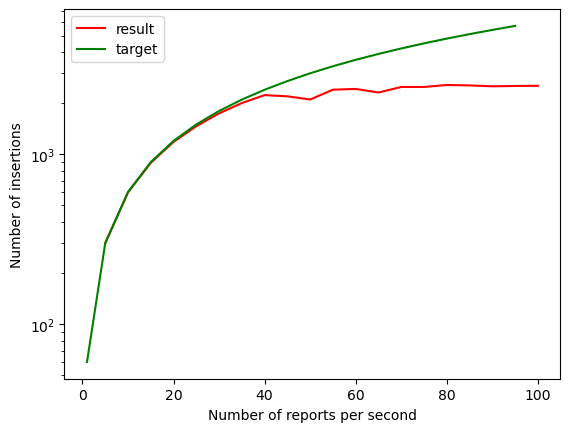

In [5]:

import matplotlib.pyplot as plt
COLOURS = "rgbcmykrgb"
plt.clf()
colour = 0

plt.plot(x_point[1:21], graph, color=COLOURS[colour], label=f"result")
colour +=1
plt.plot(x_point[:20], y_point[:20], color=COLOURS[colour], label=f"target")
plt.xlabel("Number of reports per second")
plt.ylabel("Number of insertions")
plt.yscale("log")
plt.legend()

In [6]:
import matplotlib.pyplot as plt
COLOURS = "rgbcmykrgb"
plt.clf()
colour = 0

plt.plot(x_point[1:21], graph, color=COLOURS[colour], label=f"result")
colour +=1
plt.plot(x_point, y_point, color=COLOURS[colour], label=f"target")
plt.xlabel("Number of reports per second")
plt.ylabel("Number of insertions")
plt.legend()
plt.show()

In [7]:
max_number_of_attributes = 1
plt.clf()
colour = 0
for nb_attributes in range(max_number_of_attributes):
    plt.plot(list(range(trimmed_results_from_db[f"{nb_attributes}"]["plateaux"][0]-2)), 
             trimmed_results_from_db[f"{nb_attributes}"]["intervals"][:(trimmed_results_from_db[f"{nb_attributes}"]["plateaux"][0]-2)], 
             color=COLOURS[colour%10], label=f"report {nb_attributes}")
    colour +=1

plt.xlabel("Number of insertions")
plt.ylabel("Insertion jitter (microseconds)")
plt.yscale("log")
plt.legend()
plt.show()

In [8]:
max_number_of_attributes = 1
plt.clf()
colour = 0
for nb_attributes in range(max_number_of_attributes):
    
    plt.boxplot(trimmed_results_from_db[f"{nb_attributes}"]["intervals"][:(trimmed_results_from_db[f"{nb_attributes}"]["plateaux"][0]-2)])

plt.xlabel("Number of insertions")
plt.ylabel("Insertion jitter (microseconds)")
plt.yscale("log")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


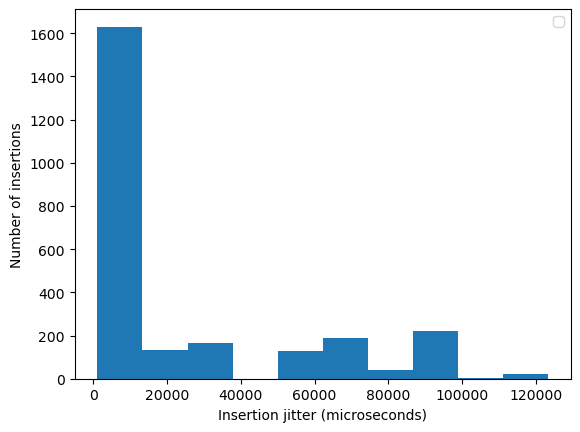

In [9]:
max_number_of_attributes = 1
plt.clf()
colour = 0
for nb_attributes in range(max_number_of_attributes):
    
    plt.hist(trimmed_results_from_db[f"{nb_attributes}"]["intervals"][:(trimmed_results_from_db[f"{nb_attributes}"]["plateaux"][0]-2)])

plt.ylabel("Number of insertions")
plt.xlabel("Insertion jitter (microseconds)")
plt.legend()
plt.show()

# EDA metrics

In [13]:
import json
max_number_of_attributes=100
max_rate_of_reporting=100
results_eda={}

for nb_attributes in range(10, max_number_of_attributes+1, 10):
    results_eda[nb_attributes]={}
    for rate in range(0, max_rate_of_reporting+1, 5):
        if rate == 0:
            real_rate = rate + 1
        else:
            real_rate = rate
        #print(f"Attributes {nb_attributes}; Rate {real_rate}")
        with open(f"./eda_result/{nb_attributes}_{real_rate}_eda_result.txt", 'r') as the_file:
            results_eda[nb_attributes][real_rate] = json.loads(the_file.read())

In [14]:
MaxProcessingTime={}
MaxStoreTime={}

for nb_attributes in range(10, max_number_of_attributes+1, 10):
    MaxProcessingTime[nb_attributes]=[]
    MaxStoreTime[nb_attributes]=[]
    for rate in range(0, max_rate_of_reporting+1, 5):
        if rate == 0:
            real_rate = rate + 1
        else:
            real_rate = rate
        #print(f"Attributes {nb_attributes}; Rate {real_rate}")
        MaxProcessingTime[nb_attributes].append(results_eda[nb_attributes][real_rate]["AttributeMaxProcessingTime"])
        MaxStoreTime[nb_attributes].append(results_eda[nb_attributes][real_rate]["AttributeMaxStoreTime"])

In [15]:
x_point = list(range(0, 101, 5))
x_point[0] = 1

In [24]:
import matplotlib.pyplot as plt
import numpy as np
COLOURS = "rgbcmykrgb"
plt.clf()
colour = 0
for nb_attributes in range(10, max_number_of_attributes+1, 10):
    plt.scatter(x_point, MaxProcessingTime[nb_attributes], color=COLOURS[colour%10], label=f"{nb_attributes} attributes")
    z = np.polyfit(x_point, MaxProcessingTime[nb_attributes], 1)
    p = np.poly1d(z)
    plt.plot(x_point,p(x_point),f"{COLOURS[colour%10]}--")
    colour +=1
plt.xlabel("Number of reports per second")
plt.ylabel("MaxProcessingTime in seconds")
plt.legend()

In [26]:
import matplotlib.pyplot as plt
COLOURS = "rgbcmykrgb"
plt.clf()
colour = 0
for nb_attributes in range(10, max_number_of_attributes+1, 10):
    plt.scatter(x_point, MaxStoreTime[nb_attributes], color=COLOURS[colour%10], label=f"{nb_attributes} attributes")
    z = np.polyfit(x_point, MaxStoreTime[nb_attributes], 1)
    p = np.poly1d(z)
    plt.plot(x_point,p(x_point),f"{COLOURS[colour%10]}--")
    colour +=1
    colour +=1
plt.xlabel("Number of reports per second")
plt.ylabel("MaxStoreTime in seconds")
plt.legend()